# Sentiment Analysis with Neural Networks

One of the common uses for binary classification in machine learning is analyzing text for sentiment — specifically, assigning a text string a score from 0 to 1, where 0 represents negative sentiment and 1 represents positive sentiment. A restaurant review such as "Best meal I've ever had and awesome service, too!" might score 0.9 or higher, while a statement such as "Long lines and poor customer service" would score closer to 0. Marketing departments sometimes use sentiment-anlysis models to monitor social-media services for feedback so they can respond quickly if, for example, comments regarding their company suddenly turn negative.

To train a neural network to perform sentiment analysis, you need a dataset containing text strings labeled with 0s (for negative sentiment) and 1s (for positive sentiment). Several such datasets are available in the public domain. We will use one containing 50,000 movie reviews, each labeled with a 0 or 1. Once the network is trained, scoring a text string for sentiment is a simple matter of passing it to the network and asking for the probability that the predicted label is 1. A probability of 80% means the sentiment score is 0.8 and that the text is very positive.

## Load and prepare the data

The first step is to load the dataset and prepare it for use in machine learning. There's no need to tokenize the text since we'll use a [`TextVectorization`](https://keras.io/api/layers/preprocessing_layers/core_preprocessing_layers/text_vectorization/) layer to do the tokenizing.

In [46]:
import pandas as pd

df = pd.read_csv('Data/reviews.csv', encoding="ISO-8859-1")
df = df.sample(frac=1, random_state=0)
df.head()

,Text,Sentiment
11841,Al Pacino was once an actor capable of making ...,0
19602,After Chaplin made one of his best films: Doug...,0
45519,This movie is sort of a Carrie meets Heavy Met...,1
25747,I have fond memories of watching this visually...,1
42642,"In the '70s, Charlton Heston starred in sci-fi...",1


Remove duplicate rows and check for balance.

In [47]:
# df.info()
df.groupby('Sentiment').describe()

Text                                                            \
           count unique                                                top   
Sentiment                                                                    
0          25000  24697  How has this piece of crap stayed on TV this l...   
1          25000  24884  Loved today's show!!! It was a variety and not...   

                
          freq  
Sentiment       
0            3  
1            5

In [48]:
df = df.drop_duplicates()
df.groupby('Sentiment').describe()

Text                                                            \
           count unique                                                top   
Sentiment                                                                    
0          24697  24697  Al Pacino was once an actor capable of making ...   
1          24884  24884  This movie is sort of a Carrie meets Heavy Met...   

                
          freq  
Sentiment       
0            1  
1            1

In [49]:
# determine max numbers and max length to reduce assumptions 

import pandas as pd

# Example: df['text'] contains your text data
text_lengths = df['Text'].apply(lambda x: len(str(x).split()))
print("Max length:", text_lengths.max())
print("Mean length:", text_lengths.mean())
print("Median length:", text_lengths.median())


Max length: 2459
Mean length: 229.05377059760795
Median length: 172.0


In [50]:
max_length = int(text_lengths.quantile(0.95))
print("Suggested max_length:", max_length)


Suggested max_length: 585


In [52]:
from collections import Counter

all_words = ' '.join(df['Text'].astype(str)).split()
word_freq = Counter(all_words)


# Decide how many unique words to keep
most_common_words = word_freq.most_common(20000)  # top 20k words
max_words_all = len(most_common_words)
# print("Max words:", max_words)

max_words_all = len(word_freq)
print("Max number of unique words:", max_words)


Max number of unique words: 413531


max_words: using all 400k+ words would be very memory-heavy and slow.

max_length: padding all sequences to 585 would waste a lot of space for short texts.

In [53]:
from collections import Counter

word_freq = Counter(all_words)
total_words = len(word_freq)  # 413531

# How many words cover 95% of occurrences?
cumulative_count = 0
total_occurrences = sum(word_freq.values())
for i, (word, count) in enumerate(word_freq.most_common()):
    cumulative_count += count
    if cumulative_count / total_occurrences > 0.95:
        print("95% coverage reached with top", i+1, "words")
        max_words = i + 1
        break

max_words

95% coverage reached with top 57612 words


57612

In [54]:
for i, (word, count) in enumerate(word_freq.most_common()):
    print(f"{i+1}: {word} ({count})")
    if i >= 9:  # Print only the top 10 words
        break

1: the (564801)
2: a (304880)
3: and (299871)
4: of (281627)
5: to (259931)
6: is (201693)
7: in (168776)
8: I (138649)
9: that (125902)
10: this (112917)


In [55]:
least_common_words = word_freq.most_common()[-10:]  # last 10 words
for i, (word, count) in enumerate(least_common_words):
    print(f"{i+1}: {word} ({count})")


1: sleazy,loser (1)
2: 71/2 (1)
3: Western'. (1)
4: monopolist (1)
5: (pre-poker (1)
6: craze) (1)
7: short-string (1)
8: Timelines (1)
9: "Chris-tu-phur!!!" (1)
10: WPT. (1)


## Train a neural network

Create a neural network containing a `TextVectorization` layer for vectorizing text, an [Embedding](https://keras.io/api/layers/core_layers/embedding/) layer for converting sequences into arrays of word vectors, and a [Dense](https://keras.io/api/layers/core_layers/dense/) layer for classifying arrays of word vectors.

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, InputLayer
from tensorflow.keras.layers import Dense, Flatten, Embedding
import tensorflow as tf

# max_words = 20000
# max_length = 500

# max_words = 57612 # determined from data
# max_length = 585
max_words = max_words
max_length = max_length
 
model = Sequential()
model.add(InputLayer(input_shape=(1,), dtype=tf.string))
model.add(TextVectorization(max_tokens=max_words, output_sequence_length=max_length))
model.add(Embedding(max_words, 32, input_length=max_length))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/Users/marlenepostop/Documents/Applied-Machine-Learning/tf_mps/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Users/marlenepostop/Documents/Applied-Machine-Learning/tf_mps/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_3            │ (None, 585)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 585, 32)        │     1,843,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     2,396,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,240,001 (16.17 MB)

 Trainable params: 4,240,001 (16.17 MB)

 Non-trainable params: 0 (0.00 B)

Extract text from the "Text" column and labels from the "Sentiment" column. Fit the `TextVectorization` layer to the text, and then train the network and capture the training history returned by `fit`.

In [57]:
x = df['Text'].astype(str).to_numpy()  
y = df['Sentiment'].to_numpy()

model.layers[0].adapt(x)

hist = model.fit(x, y, validation_split=0.2, epochs=5, batch_size=250)


Epoch 1/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7494 - loss: 0.4696 - val_accuracy: 0.8721 - val_loss: 0.3017
Epoch 2/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9395 - loss: 0.1663 - val_accuracy: 0.8807 - val_loss: 0.2857
Epoch 3/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9930 - loss: 0.0336 - val_accuracy: 0.8752 - val_loss: 0.3541
Epoch 4/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9990 - loss: 0.0078 - val_accuracy: 0.8772 - val_loss: 0.3865
Epoch 5/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9998 - loss: 0.0022 - val_accuracy: 0.8741 - val_loss: 0.4289


See how the training and validation accuracy evolved and make sure the network was trained for a sufficient number of epochs.

[]

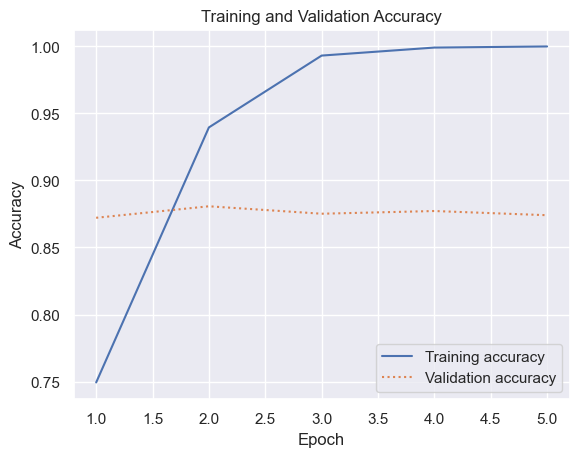

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

## Use the model to analyze text

Let's score a couple of reviews by passing them to the model's `predict` method. Start with a positive review.

tf.constant is a TensorFlow function that creates a Tensor with a fixed value.

A tensor is basically a multi-dimensional array, like a NumPy array, but designed to work with TensorFlow operations.

tf.constant is used to make sure TensorFlow knows the type (dtype) of the data and can use it in models.
Your CNN starts with a TextVectorization layer, which expects a tensor of strings (dtype=tf.string).

In [65]:
text = 'Excellent food and fantastic service!'
pred_prob = model.predict(tf.constant([text]))[0][0]

if pred_prob > 0.5:
    print(f"Positive sentiment ({pred_prob:.2f})")
else:
    print(f"Negative sentiment ({pred_prob:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Positive sentiment (1.00)


And then a negative review.

Do the sentiment scores output by the model seem accurate?

In [39]:
#original

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, InputLayer
from tensorflow.keras.layers import Dense, Flatten, Embedding
import tensorflow as tf

max_words = 20000
max_length = 500

# max_words = 57612 # determined from data
# max_length = 585
 
model = Sequential()
model.add(InputLayer(input_shape=(1,), dtype=tf.string))
model.add(TextVectorization(max_tokens=max_words, output_sequence_length=max_length))
model.add(Embedding(max_words, 32, input_length=max_length))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/Users/marlenepostop/Documents/Applied-Machine-Learning/tf_mps/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 500)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 500, 32)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     2,048,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,688,257 (10.25 MB)

 Trainable params: 2,688,257 (10.25 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
x = df['Text'].astype(str).to_numpy()  
y = df['Sentiment'].apply(lambda x: 1 if x == 'positive' else 0).to_numpy()

model.layers[0].adapt(x)

hist = model.fit(x, y, validation_split=0.2, epochs=5, batch_size=250)

Epoch 1/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9994 - loss: 0.0061 - val_accuracy: 1.0000 - val_loss: 9.9717e-14
Epoch 2/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 1.0000 - loss: 9.0259e-14 - val_accuracy: 1.0000 - val_loss: 9.9717e-14
Epoch 3/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 1.0000 - loss: 9.0259e-14 - val_accuracy: 1.0000 - val_loss: 9.9717e-14
Epoch 4/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 1.0000 - loss: 9.0259e-14 - val_accuracy: 1.0000 - val_loss: 9.9717e-14
Epoch 5/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 1.0000 - loss: 9.0259e-14 - val_accuracy: 1.0000 - val_loss: 9.9717e-14


#val accuracy is too high?
#overfitting?

Shuffle data?

In [41]:
from sklearn.utils import shuffle

x, y = shuffle(x, y, random_state=42)


In [43]:
#check 1/0

df['Sentiment'].value_counts()

Sentiment
1    24884
0    24697
Name: count, dtype: int64

In [42]:
for i in range(5):
    print(x[i], y[i])


Well, 1st off I haven't seen "Silence of the Lambs" yet.... but, I think that I would have become sick if I would have seen it before this piece. Not from the gruesome violence but, from the lack of everything else. Anthony Hopkins was very good as Hannibal and I really believed that he was as psychotic as he played himself off to be but, from the reaction of the audience around me, the film was filled with cliches from "Silence" which left me lost at points where others were laughing at what was on the screen. Now, I heard that the movie would be very gruesome and if the director wanted to gross folks out... he did it... but, only in 2 sequences? I mean, if you want it to be gruesome and I mean, so gruesome that you're going to play the film off of that... you need more than 2 sequences.. I always see it as a film has to either become that cinematic jewel which will ultimatley take you to another place and time or either go over the top (which most of the time is done in bad taste). B

In [45]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=32)


Epoch 1/5
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 1.0000 - loss: 9.1360e-14 - val_accuracy: 1.0000 - val_loss: 9.5314e-14
Epoch 2/5
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 1.0000 - loss: 9.1360e-14 - val_accuracy: 1.0000 - val_loss: 9.5314e-14
Epoch 3/5
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 1.0000 - loss: 9.1360e-14 - val_accuracy: 1.0000 - val_loss: 9.5314e-14
Epoch 4/5
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 1.0000 - loss: 9.1360e-14 - val_accuracy: 1.0000 - val_loss: 9.5314e-14
Epoch 5/5
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 1.0000 - loss: 9.1360e-14 - val_accuracy: 1.0000 - val_loss: 9.5314e-14
